In [42]:
import numpy as np
import a5_utils as a5
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

### Exercise 1: Disparity

#### (a)

Na papirju...

d = x1 - x2 = T * f / pz

Disparity increases the closer the object gets to the cameras.

#### (b)

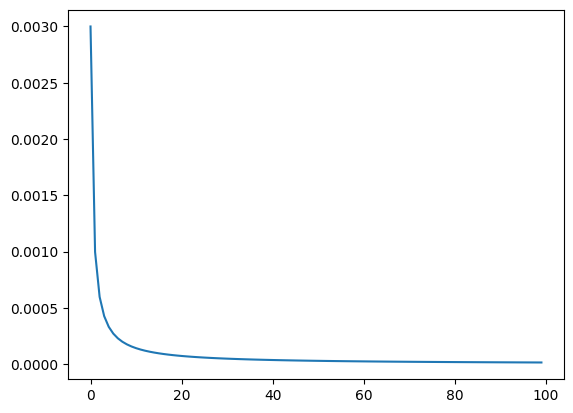

In [43]:
f = 2.5 * 1e-3 #mm -> m
T = 12 * 1e-2 #cm -> m

def disparity(T, f, pz): return T * f / pz

pz = np.linspace(0.1, 20, num=100) #m
d = disparity(T, f, pz)

plt.plot(d)
plt.show()

#### (c)

In [44]:
f = 2.5 * 1e-3 #mm -> m
T = 12 * 1e-2 #cm -> m
w = 648 #px
h = 488 #px
pix_w = 7.4 * 10e-6 #um -> m
point_x_left = 550 #px
point_x_right = 300 #px
point2_x_right = 540 #px

# izracun: papir
# 550px in 300 px : pz = 162.16 mm
# 550px in 540 px : pz = 4.29 m

#### (d)

In [45]:
d1office1 = cv2.imread("data/disparity/office_left.png")
d1office1 = cv2.cvtColor(d1office1, cv2.COLOR_RGB2GRAY)
d1office2 = cv2.imread("data/disparity/office_right.png")
d1office2 = cv2.cvtColor(d1office2, cv2.COLOR_RGB2GRAY)

In [46]:
def ncc(x, y):
    avgx = np.average(x)
    avgy = np.average(y)
    res = (
        np.sum(
            (x - avgx) * (y - avgy)
        )
        /
        np.sqrt(
            np.sum((x - avgx)**2)
            *
            np.sum((y - avgy)**2)
        )
    )
    return res

In [47]:
# ncc_matches = cv2.matchTemplate(d1office1, d1office2, cv2.TM_CCORR_NORMED)
# maxncc = np.argmax(ncc_matches)[0]
# mnx = maxncc // ncc_matches.shape[1]
# mny = maxncc % ncc_matches.shape[0]

In [48]:
# patchsize = 10
# height, width = d1office1.shape
# nccs = []
# for y in range(height-patchsize):
#     for x in range(width-patchsize):
#         nccs.append(
#             ncc(d1office1[y:y+patchsize, x:x+patchsize],
#                 d1office2[y:y+patchsize, x:x+patchsize])
#         )

### Exercise 2: Fundamental matrix, epipoles, epipolar lines

#### (a)

In [49]:
# papir
#-----------
# c=0, r=2 : y = 1
# c=1, r=0 : x = 1

#### (b)

In [50]:
def fundamental_matrix(p_img1, p_img2):

    #apply the normalization
    p1t, T1 = a5.normalize_points(p_img1)
    p2t, T2 = a5.normalize_points(p_img2)

    x1s = p1t
    x2s = p2t


    #make matrix A
    A = np.zeros((len(x1s),9))
    for i in range(len(x1s)):
        u, v, w = x1s[i]
        u_, v_, w_ = x2s[i]
        A[i] = [u*u_, u_*v, u_, u*v_, v*v_, v_, u, v, 1]

    #do SVD
    U, D, V = np.linalg.svd(A)

    #last column of V (dont forget about the transpose!)
    f = V.T[:, -1]
    F = f.reshape(3, 3)

    #denormalize
    F = np.dot(np.dot(T2.T, F), T1)

    #decomposition of F
    Uf1, Df1, Vf1 = np.linalg.svd(F)
    # Df1[-1,-1] = 0 #lowest eigenval to 0
    Df1 = np.diag(Df1)
    Df1[-1] = 0

    #reconstruct F
    Fr = np.dot(np.dot(Uf1, Df1), Vf1)

    #decompose again
    Uf2, Df2, Vf2 = np.linalg.svd(Fr)

    #compute epipoles
    e = [Vf2[0,2], Vf2[1,2], Vf2[2,2]] / Vf2[2,2]
    e_ = [Uf2[0,2], Uf2[1,2], Uf2[2,2]] / Uf2[2,2]

    return F, e, e_

In [51]:
house_points = np.loadtxt("data/epipolar/house_points.txt")
b2f, b2e, b2e_ = fundamental_matrix(house_points[:, 0:2], house_points[:, 2:4])
house_fund = np.loadtxt("data/epipolar/house_fundamental.txt")
print(b2f)
print("-----------------------------------------------------")
print(house_fund)
print("-----------------------------------------------------")
print(house_fund - b2f)

[[-6.41801577e-07 -5.61386435e-06  1.88797992e-03]
 [ 9.41677335e-06  6.17085383e-07 -1.20120556e-02]
 [-1.25849261e-03  1.10365393e-02 -7.27679606e-02]]
-----------------------------------------------------
[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]
-----------------------------------------------------
[[-2.43410247e-07 -2.05444902e-09  5.51295936e-05]
 [-2.39546517e-08 -2.02183824e-10  5.42545031e-06]
 [ 5.54084718e-05  4.67662649e-07 -1.25493753e-02]]


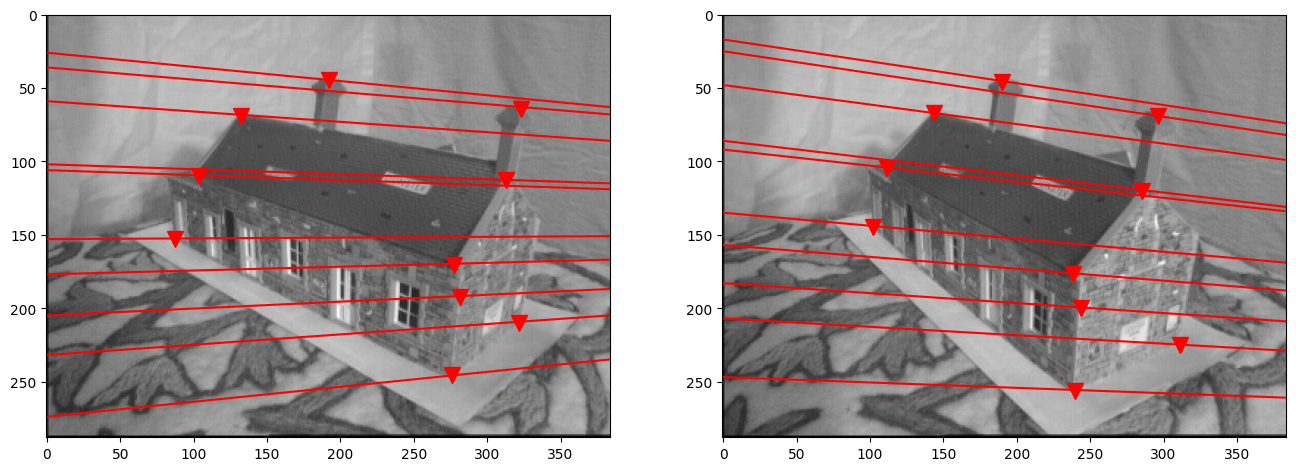

In [52]:
b2house1 = cv2.imread("data/epipolar/house1.jpg")
b2house1 = cv2.cvtColor(b2house1, cv2.COLOR_RGB2GRAY)
b2house2 = cv2.imread("data/epipolar/house2.jpg")
b2house2 = cv2.cvtColor(b2house2, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
plt.imshow(b2house1, cmap="gray")
for i in range(len(house_points)):
    point1 = [house_points[i, 0], house_points[i, 1], 1]
    plt.plot(point1[0], point1[1], "rv", markersize=12)
    point2 = [house_points[i, 2], house_points[i, 3], 1]
    l = np.dot(b2f.T, point2)
    a5.draw_epiline(l, b2house1.shape[0], b2house1.shape[1])
plt.subplot(1, 2, 2)
plt.imshow(b2house2, cmap="gray")
for i in range(len(house_points)):
    point1 = [house_points[i, 2], house_points[i, 3], 1]
    plt.plot(point1[0], point1[1], "rv", markersize=12)
    point2 = [house_points[i, 0], house_points[i, 1], 1]
    l_ = np.dot(b2f, point2)
    a5.draw_epiline(l_, b2house2.shape[0], b2house2.shape[1])
plt.show()

#### (c)

In [53]:
def reprojection_error(F, p1, p2):
    
    p1h = np.concatenate((p1, [1])) #to homogenous
    p2h = np.concatenate((p2, [1]))

    l = np.dot(F.T, p2h)
    l_ = np.dot(F, p1h)

    x, y, c = l
    x_, y_, c_ = l_

    distance = (
        np.abs(x*p1h[0] + y*p1h[1] + c)
        /
        np.sqrt(x**2 + y**2)
    )
    distance_ = (
        np.abs(x_*p2h[0] + y_*p2h[1] + c_)
        /
        np.sqrt(x_**2 + y_**2)
    )

    return (distance + distance_) / 2

In [54]:
#test1
t1p1 = [85, 233]
t1p2 = [67, 219]
c2f, _, _ = fundamental_matrix(house_points[:, 0:2], house_points[:, 2:4])
t1err1 = reprojection_error(house_fund, t1p1, t1p2)
print(t1err1)

0.14674365643746756


In [55]:
#test2
t2p1s, t2p2s = house_points[:, 0:2], house_points[:, 2:4]
t2avgerr = 0
for i in range(len(house_points)):
    t2avgerr += reprojection_error(house_fund, t2p1s[i], t2p2s[i])
t2avgerr /= len(house_points)
print(t2avgerr)

0.33091337127131937


### Exercise 3: Triangulation

#### (a)

In [56]:
def triangulate(pts1, pts2, cm1, cm2):
    solpts = []
    for i in range(len(pts1)):
        #points --> homogenouse
        pt1h = np.concatenate((pts1[i], [1]))
        pt2h = np.concatenate((pts2[i], [1]))
        #make shear-symmetric form of x
        x1ss = np.zeros((3,3))
        x2ss = np.zeros((3,3))
        x1ss[0] = [0, -pt1h[2], pt1h[1]]
        x1ss[1] = [pt1h[2], 0, -pt1h[0]]
        x1ss[2] = [-pt1h[1], pt1h[0], 0]
        x2ss[0] = [0, -pt2h[2], pt2h[1]]
        x2ss[1] = [pt2h[2], 0, -pt2h[0]]
        x2ss[2] = [-pt2h[1], pt2h[0], 0]
        #combine to matrix A
        A = np.zeros((4,4))
        A[0:2, :] = np.dot(x1ss, cm1)[0:2, :]
        A[2:4, :] = np.dot(x2ss, cm2)[0:2, :]
        #solve AX = 0
        _, _, V = np.linalg.svd(A)
        X = V.T[:, 3]
        X = X / X[-1]
        #save
        solpts.append(X[0:3]) #without the homog. 4th coord
    return solpts

In [57]:
house1cam = np.loadtxt("data/epipolar/house1_camera.txt")
house2cam = np.loadtxt("data/epipolar/house2_camera.txt")
trng3dpts = np.array(triangulate(house_points[:, 0:2], house_points[:, 2:4], house1cam, house2cam))
T=np.array([[-1, 0,  0],
           [0,  0, -1],
           [0,  1,  0]])
pts3dtrans = np.copy(trng3dpts)
for i in range(len(pts3dtrans)):
    pts3dtrans[i] = np.dot(T, pts3dtrans[i])

xpts = pts3dtrans[:, 0]
ypts = pts3dtrans[:, 1]
zpts = pts3dtrans[:, 2]

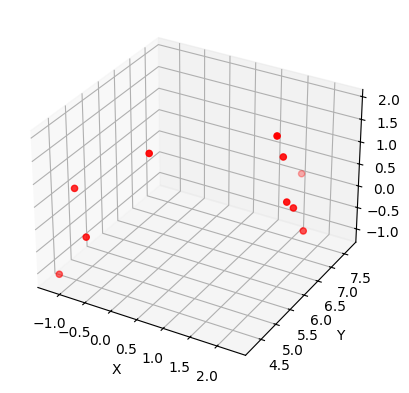

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xpts, ypts, zpts, c='r', marker='o')
def update(frame):
    ax.view_init(elev=20, azim=frame)
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()